# Digit Recognizer with CNN

## Inroduction

For this final project we will be participating in Kaggle's [Digit Recognizer competition](https://www.kaggle.com/competitions/digit-recognizer/overview).

This competition offers us to practice our skills on the classic MNIST dataset of handwritten digit images which is a de facto "Gold standard" for benchmarking classification algorithms.

Our goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. To solve this problem we will build and train a Convolutional Neural Network.

GitHub repository for this project can be found at https://github.com/nabilahforuni/digit_recognizer

## Loading data and EDA

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-06-11 07:27:56.350448: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 07:27:56.350542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 07:27:56.540500: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
submission_df = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')

In [3]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
submission_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


As we can see, the training dataset contains 42000 samples with one label column and 784 columns for pixels of 28x28 image. Testing dataset consists of 28000 samples with the same number of columns minus the one with the label, which is our goal to predict.

Let's quickly check for any missing data.

In [8]:
train_df.isna().any(axis=1).any()

False

In [9]:
test_df.isna().any(axis=1).any()

False

No missing values. Let's see how the data distributed between the labels.

<Axes: xlabel='label'>

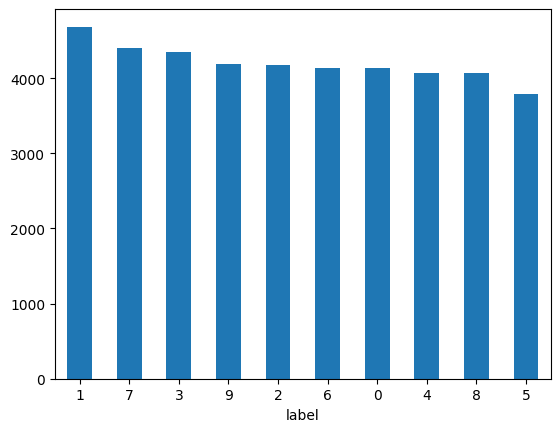

In [10]:
train_df.label.value_counts().plot.bar(rot=0)

Dataset is pretty evenly distributed.

Finally, let's take a look at some of the images.

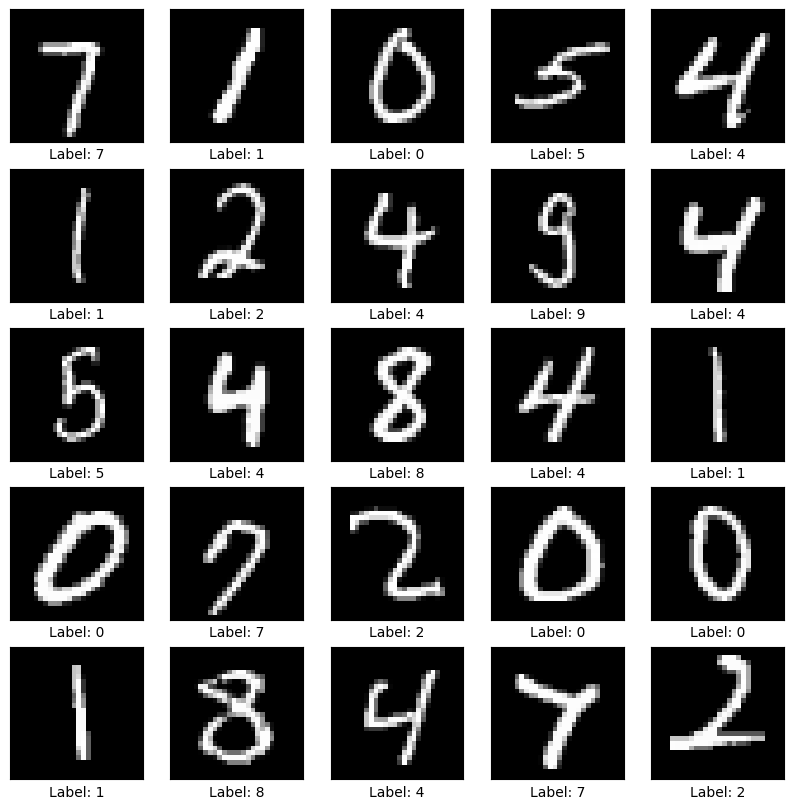

In [11]:
plt.figure(figsize=(10, 10))
for i, (label, *img) in train_df.sample(25).reset_index(drop=True).iterrows():
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    img = np.array(img).reshape((28, 28))
    plt.imshow(img, cmap='gray')
    plt.xlabel(f'Label: {label}')

## Data preprocessing

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
img_size = (28, 28)

First, separate labels from the image data.

In [13]:
y_train = train_df['label'].to_numpy()
x_train = train_df.drop(columns='label').to_numpy()
print(x_train.shape)

(42000, 784)


Second, reshape image data from a single row to a 28x28 matrix.

In [14]:
x_train = x_train.reshape(-1, *img_size)
x_train.shape

(42000, 28, 28)

Third, one-hot encode the labels.

In [15]:
y_train = tf.keras.utils.to_categorical(y_train)
y_train.shape

(42000, 10)

Now let's create the Tensorflow Dataset object with the prepared data.

In [16]:
ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=42000>

Split data into trainging and validation sets.

In [17]:
ds_size = ds.cardinality().numpy()
val_size = int(0.2 * ds_size)
train_size = ds_size - val_size
print(f'Training set size: {train_size}')
print(f'Validation set size: {val_size}')

Training set size: 33600
Validation set size: 8400


In [18]:
train_ds = ds.take(train_size)
val_ds = ds.skip(train_size)

Configure datasets for performance.

In [19]:
def configure_for_performance(ds, shuffle=True):
    ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [20]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

## CNN architecture

First, prepare the function to plot the training results.

In [21]:
def plot_history(history):    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(16, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Loss')
    plt.show()

The architecture of our CNN is pretty standard: a stack of convolutional and max pooling layers with additional dropout and batch normalization layers. On top of that we have one fully-connected layer of 128 neurons with ReLU activation function and finally the output layer with 10 neurons and softmax activation.

To make this notebook run in a reasonable amount of time, we only provide the final version of the architecture to which we have arrived after iterating through a number of options and choosing the best one.

In [22]:
num_classes = 10

model = tf.keras.Sequential([
    tf.keras.layers.Input(img_size + (1,)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,722 (405.16 KB)

 Trainable params: 103,466 (404.16 KB)

 Non-trainable params: 256 (1.00 KB)

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])

In [24]:
epochs = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
  51/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3059 - loss: 2.4547

I0000 00:00:1718090908.038161      69 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1050/1050 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.8245 - loss: 0.5676 - val_accuracy: 0.9846 - val_loss: 0.0497
Epoch 2/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9734 - loss: 0.0827 - val_accuracy: 0.9846 - val_loss: 0.0474
Epoch 3/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9788 - loss: 0.0670 - val_accuracy: 0.9899 - val_loss: 0.0349
Epoch 4/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9830 - loss: 0.0552 - val_accuracy: 0.9858 - val_loss: 0.0480
Epoch 5/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9864 - loss: 0.0418 - val_accuracy: 0.9900 - val_loss: 0.0397
Epoch 6/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9873 - loss: 0.0379 - val_accuracy: 0.9868 - val_loss: 0.0436
Epoch 7/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9880 - loss: 0.0358 - val_accuracy: 0.9906 - val_loss: 0.0426
Epoch 8/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9886 - loss: 0.0335 - val_accura

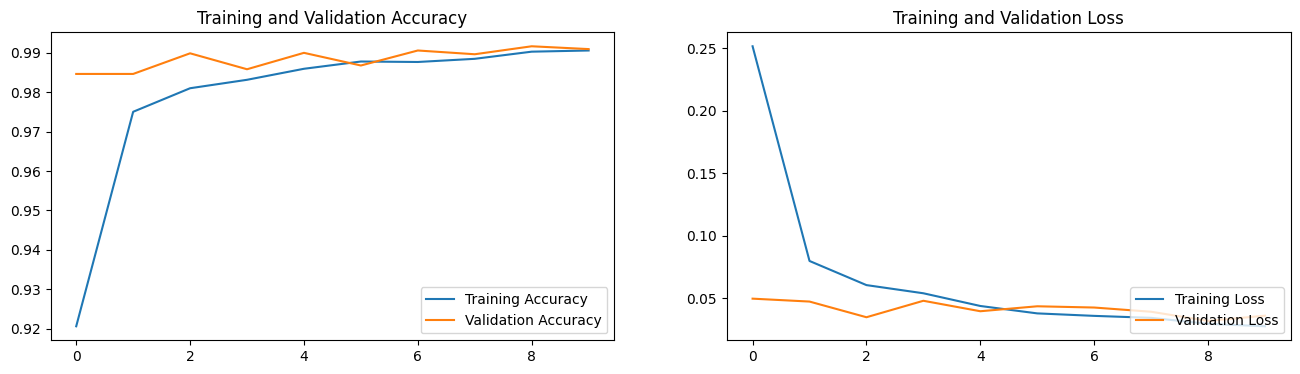

In [25]:
plot_history(history)

We get pretty good results with around 99% accuracy (frankly, for this classic task anything less than that should be considered a complete and utter failure when using neural networks).

No signs of overfitting either as training and validation accuracy are nearly equal at end of the training process.

## Making a submission

In [26]:
model.save('/kaggle/working/model.keras')

In [27]:
test = test_df.values.reshape(-1, *img_size)
test.shape

(28000, 28, 28)

In [28]:
test_ds = tf.data.Dataset.from_tensor_slices(test)
test_ds.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=28000>

In [29]:
test_ds = configure_for_performance(test_ds, shuffle=False)

In [30]:
raw_predictions = model.predict(test_ds)

875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [31]:
predictions = np.argmax(raw_predictions, axis=1)
predictions.shape

(28000,)

In [32]:
submission_df.Label = predictions
submission_df

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [33]:
submission_df.to_csv('/kaggle/working/submission.csv', index=False)

## Conclusion

Our submission to the competition received a score of 0.99067.

This is a good illustration of why CNNs and deep neural networks in general has taken the world of computer vision by storm.

## References

[1] https://www.tensorflow.org/tutorials/load_data/pandas_dataframe

[2] https://www.tensorflow.org/tutorials/load_data/images

[3] https://www.tensorflow.org/guide/core/mlp_core

[4] https://www.tensorflow.org/tutorials/images/cnn